In [ ]:
### Importing all the needed stuff

import os
import sys
import torch
import torchvision
import zipfile
import shutil
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
data_dir = "./data"

### NOTE: the below paths will need to be changes in other systems.

if os.path.exists(data_dir+"/train/cat") and os.path.exists(data_dir+"/train/dog"):
    ### If the above conditions are satisfied, we assume that the data is processed
    ### Meaning, the data has already been organized & the images have been shrunk.
    pass

else:
    ### If the above condition fails, then we process the zipfile in below mentioned ways.
    if not os.path.exists('/content/drive/MyDrive/dogs-vs-cats.zip'):
        sys.exit("Extracted data wasn't found & neither was the zipped dataset was found.")
    
    ### Clearing the folder before storing data
    !rm -rf ./data

    ### Since the data is zipped, we extracted the data here.
    with zipfile.ZipFile('/content/drive/MyDrive/dogs-vs-cats.zip') as z:
        z.extractall(path='./data')

    with zipfile.ZipFile('./data/test1.zip') as z:
        z.extractall(path='./data')

    with zipfile.ZipFile('./data/train.zip') as z:
        z.extractall(path='./data')

    os.mkdir('./data/train/cat')
    os.mkdir('./data/train/dog')
    os.mkdir('./data/test1/unknown')

    ### The cats' & dogs' images are in the same folder,
    ### with only segregation being different beginings of filenames.
    ### We create different directories to save the images as per their names.

    for filename in os.scandir('./data/train'):
        if(filename.name == 'cat' or filename.name == 'dog'):
            pass
        else:
            if filename.name.startswith('cat'):
                shutil.move(filename.path, './data/train/cat/'+filename.name[4:])
            elif filename.name.startswith('dog'):
                shutil.move(filename.path, './data/train/dog/'+filename.name[4:])

    for filename in os.scandir('./data/test1'):
        if(filename.name != 'unknown'):
            shutil.move(filename.path, './data/test1/unknown/'+filename.name)

    ### Removing unneccessary zip files
    !rm ./data/test1.zip
    !rm ./data/train.zip
    !rm ./data/sampleSubmission.csv

    ### Since all the files were of different sizes, we resize them to achieve consistency in the data.
    ### Since the images are very large, it is best if we strink it.
    shrink_to = 100

    for image_file in os.scandir(data_dir+"/train/cat"):
        img_file = Image.open(image_file.path)
        better_img = img_file.resize((shrink_to,shrink_to))
        better_img.save(image_file.path)

    for image_file in os.scandir(data_dir+"/train/dog"):
        img_file = Image.open(image_file.path)
        better_img = img_file.resize((shrink_to,shrink_to))
        better_img.save(image_file.path)

    for image_file in os.scandir(data_dir+"/test1/unknown"):
        img_file = Image.open(image_file.path)
        better_img = img_file.resize((shrink_to,shrink_to))
        better_img.save(image_file.path)

In [ ]:
### Some bits about data:

print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/train")
print(classes)

['train', 'test1']
['dog', 'cat']


In [ ]:
cat_files = os.listdir(data_dir + "/train/cat")
dog_files = os.listdir(data_dir + "/train/dog")

print("No. of cat images for training: ", len(cat_files))
print("No. of dog images for training: ", len(dog_files))

No. of cat images for training:  12500
No. of dog images for training:  12500


In [ ]:
test_files = os.listdir(data_dir+"/test1")

len(test_files)

1

In [ ]:
dataset = ImageFolder(data_dir+"/train", transform=ToTensor())

torch.Size([3, 100, 100]) 0


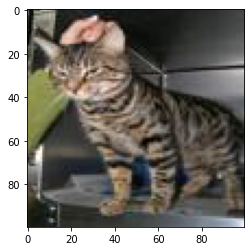

In [ ]:
### Sample, (Label '0': Cat, Label '1': Dog)

img, label = dataset[1544]
print(img.shape, label)
plt.imshow(img.permute(1,2,0))

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 2500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(22500, 2500)

In [ ]:
### Creating Dataloaders for Training Set & Validation Set

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize=(24,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs, nrow=16).permute(1,2,0))
        break

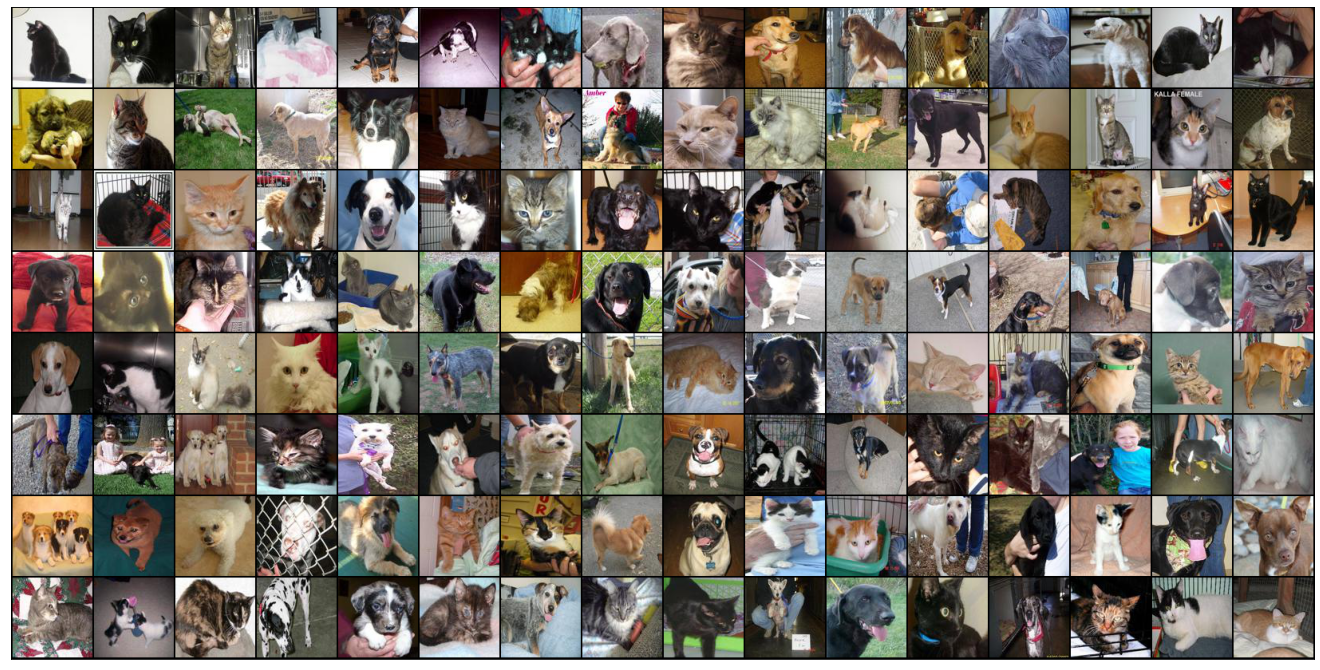

In [ ]:
### Bunch of smaple images in training set

show_batch(train_dl)

In [ ]:
### Base Module for general purpose Neural Network
### It will used in conjunction with CNN.

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
### Here we create a Network of CNN and link it with the base module.

class DogCatClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential( # Starting with : 3x100x100
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output : 128x50x50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output : 256x25x25

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(5,5), # Output : 256x5x5

            nn.Flatten(),
            nn.Linear(256*5*5, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,2)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = DogCatClassifier()
model

DogCatClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
### Here we shift the model to GPU, if possible using Torch->Cuda

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
### Fetch info, to check if GPU is available.

device = get_default_device()
device

device(type='cuda')

In [ ]:
### Shifting all the dataloaders to GPU.

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

DogCatClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(DogCatClassifier(), device)

In [ ]:
evaluate(model, val_dl) ### Random Initialization of model biases.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'val_acc': 0.4950494170188904, 'val_loss': 0.6932206153869629}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
### We fit the model with decided hyperparameters.
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6928, val_loss: 0.7525, val_acc: 0.5037
Epoch [1], train_loss: 0.6511, val_loss: 0.5657, val_acc: 0.7078
Epoch [2], train_loss: 0.5503, val_loss: 0.4957, val_acc: 0.7510
Epoch [3], train_loss: 0.4853, val_loss: 0.4685, val_acc: 0.7862
Epoch [4], train_loss: 0.4344, val_loss: 0.4272, val_acc: 0.8005
Epoch [5], train_loss: 0.3863, val_loss: 0.4239, val_acc: 0.8138
Epoch [6], train_loss: 0.3542, val_loss: 0.3783, val_acc: 0.8381
Epoch [7], train_loss: 0.3089, val_loss: 0.3764, val_acc: 0.8383
Epoch [8], train_loss: 0.2722, val_loss: 0.3721, val_acc: 0.8391
Epoch [9], train_loss: 0.2265, val_loss: 0.3993, val_acc: 0.8385


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

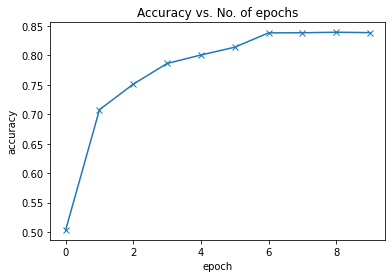

In [ ]:
### As can be seen from the plot that the accuracy is increasing with each iteration.

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

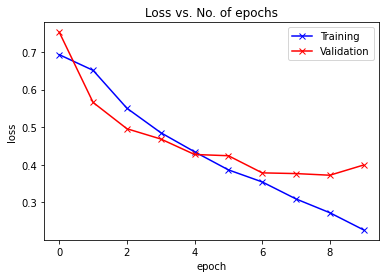

In [ ]:
### Here we see that the Training loss is continously decreasing,
### But the validation loss has started to increase mid-way.
### This proves that the model has overfitting.

plot_losses(history)

In [ ]:
def predict(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [ ]:
### The ImageFolder function assumes the images to be in their respective categories,
### but we didn't prior segregation in the test images, thus we had added the images to another folder to skip a possible error.
test_dataset = ImageFolder(data_dir+"/test1", transform=ToTensor())

Predicted:  dog


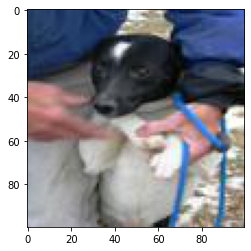

In [ ]:
### Few random predictions from the testset.
### Do note, the given testset wasn't segregated prior.

img, label = test_dataset[0]
plt.imshow(img.permute(1,2,0))
print('Predicted: ', predict(img, model))

Predicted:  dog


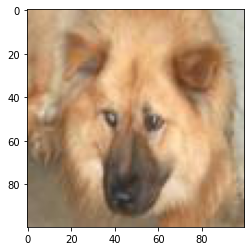

In [ ]:
img, label = test_dataset[1120]
plt.imshow(img.permute(1,2,0))
print('Predicted: ', predict(img, model))

Predicted:  cat


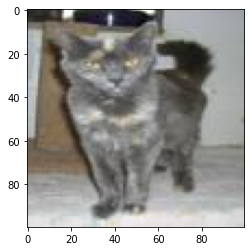

In [ ]:
img, label = test_dataset[4458]
plt.imshow(img.permute(1,2,0))
print('Predicted: ', predict(img, model))

Predicted:  cat


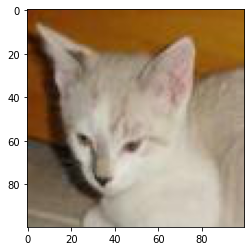

In [ ]:
img, label = test_dataset[12112]
plt.imshow(img.permute(1,2,0))
print('Predicted: ', predict(img, model))

In [ ]:
### Finally Saving the model.

torch.save(model.state_dict(), 'Cat-Dog-Classifier.pth')